## init

In [1]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


In [2]:
our_s = sneaky.SneakyMatrix.eye(5)
our_s.add_cols(0, 1)
print(our_s.columns())
our_s.swap_cols_and_rows(0,1 )
print(our_s.columns())
its_s = mars.SneakyMatrix.from_py_sneakymatrix(our_s)
for i in range(2):
  for j in range(2):
    print(f'{i},{j} = {its_s.get(i,j)}')


[(0, [0, 1]), (1, [1]), (2, [2]), (3, [3]), (4, [4])]
[(0, [0]), (1, [0, 1]), (2, [2]), (3, [3]), (4, [4])]
0,0 = True
0,1 = True
1,0 = False
1,1 = True


In [2]:
example = ex.cube_1
our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    print(f'faustian: {s1} {s2} {a} {b}')

(cx, cy, cz) = gridd.center_index()
cx += 2
v = vineyard2(our_complex)
state0 = v.reduce((cx, cy, cz), version=vin.Version.Sparse)
state1 = v.reduce_vine(state0, gridd.coordinate((cx+1, cy, cz)))

utils.Timed.report()

faustian: simplex v11 bd [-1] simplex v3 bd [-1] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e20 bd [13, 21] simplex e17 bd [13, 3] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e4 bd [21, 11] simplex e5 bd [11, 3] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e68 bd [11, 12] simplex e61 bd [2, 12] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e34 bd [18, 0] simplex e35 bd [0, 24] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e53 bd [20, 11] simplex e27 bd [3, 10] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e48 bd [21, 14] simplex e52 bd [13, 7] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex v21 bd [-1] simplex v11 bd [-1] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e16 bd [25, 13] simplex e15 bd [3, 25] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e13 bd [24, 12] simplex e14 bd [12, 6] (8, 6, 6) [0.75 0.15 0.15]
faustian: simplex e7 bd [22, 14] simplex e8 bd [14, 7] (8, 6, 6) [0.75 0.15 0.15]
|======== Timed report ========
| reduce sparse                   :      68.36ms  (68.362ms per;

faustian: simplex v10 bd [-1] simplex v3 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e56 bd [10, 11] simplex e27 bd [3, 10] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v11 bd [-1] simplex v10 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v13 bd [-1] simplex v11 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e16 bd [25, 13] simplex e17 bd [13, 3] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e4 bd [21, 11] simplex e5 bd [11, 3] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e20 bd [13, 21] simplex e15 bd [3, 25] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e28 bd [10, 25] simplex e56 bd [10, 11] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v20 bd [-1] simplex v13 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e53 bd [20, 11] simplex e28 bd [10, 25] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex v21 bd [-1] simplex v20 bd [-1] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e34 bd [18, 0] simplex e35 bd [0, 24] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e68 bd [11, 12] simplex e60 bd [8, 2] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e48 bd [21, 14] simplex e52 bd [13, 7] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e57 bd [13, 16] simplex e21 bd [7, 16] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e7 bd [22, 14] simplex e8 bd [14, 7] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e26 bd [15, 24] simplex e25 bd [6, 15] (6, 6, 6) [0.35 0.15 0.15]
faustian: simplex e22 bd [16, 22] simplex e57 bd [13, 16] (6, 6, 6) [0.35 0.15 0.15]



|======== Timed report ========
| reduce sparse                   :      21.09ms  (21.090ms per; #1)
| vineyard.get_state_at_point     :      86.17ms  ( 0.002ms per; #34914)
| reduce_vine: ordering           :   10191.11ms  ( 0.292ms per; #34914)
| reduce_vine: transpositions_lean:   11199.78ms  ( 0.321ms per; #34914)
| from sparse                     :       3.76ms  ( 0.627ms per; #6)
| reduce_vine: loop               :    1094.01ms  ( 0.031ms per; #34914)
| reduce_vine RS                  :    1636.95ms  ( 0.047ms per; #34914)
|==============================


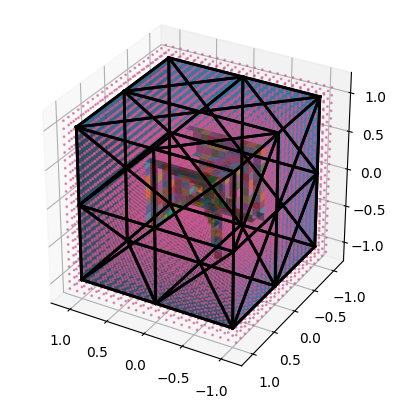

In [8]:
example = ex.cube_2

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    if s1.dim() == 0:
      cob1 = set(our_complex.get_coboundary(s1))
      cob2 = set(our_complex.get_coboundary(s2))
      if cob1 & cob2:
        return
      c1 = gridd.cell_of(a)
      c2 = gridd.cell_of(b)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point, version=vin.Version.Sparse)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)

sparse: 1m 46s

RS: 4.8s



|======== Timed report ========
| reduce sparse                   :      21.09ms  (21.090ms per; #1)
| vineyard.get_state_at_point     :      86.17ms  ( 0.002ms per; #34914)
| reduce_vine: ordering           :   10191.11ms  ( 0.292ms per; #34914)
| reduce_vine: transpositions_lean:   11199.78ms  ( 0.321ms per; #34914)
| from sparse                     :       3.76ms  ( 0.627ms per; #6)
| reduce_vine: loop               :    1094.01ms  ( 0.031ms per; #34914)
| reduce_vine RS                  :    1636.95ms  ( 0.047ms per; #34914)
|==============================


